In [13]:
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [14]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import time
import matplotlib.pyplot as plt

In [15]:
from data_helpers.wine_quality_data_helper import load_wine_quality_data
from data_helpers.mnist_data_helper import load_mnist_data

In [16]:
class GaussianMixtureWrapper:
    NAME = 'GMM'
    def __init__(self, n_components):
        self.n_components = n_components
        self.model = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        return self.model.predict(X)
    
    def bic(self, X):
        return self.model.bic(X)

    def aic(self, X):
        return self.model.aic(X)

class KMeansWrapper:
    NAME = 'KMeans'
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=n_clusters)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        return self.model.predict(X)
    
    def inertia(self):
        return self.model.inertia_

In [17]:
DATASET_NAME = 'mnist'

dataset_to_str = {'mnist': 'MNIST', 'wine_quality': 'Wine Quality'}
DATASET_STR = dataset_to_str[DATASET_NAME]

DIM_RED_METHOD = 'PCA'
# DIM_RED_METHOD = 'ICA'

SAVE = True

METHOD = KMeansWrapper

if DIM_RED_METHOD == 'PCA':
    num_components = 50
elif DIM_RED_METHOD == 'ICA':
    num_components = 75

In [18]:
if DATASET_NAME == 'wine_quality':
    DATASET_STR = 'Wine Quality'
    X, y, _, _ = load_wine_quality_data()
elif DATASET_NAME == 'mnist':
    DATASET_STR = 'MNIST'
    X, y, _, _ = load_mnist_data()
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

In [19]:
import pickle
if DATASET_NAME == 'wine_quality':
    DATASET_STR = 'Wine Quality'
    X_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_train.pkl', 'rb'))
    y_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_train.pkl', 'rb'))
    X_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_test.pkl', 'rb'))
    y_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_test.pkl', 'rb'))
elif DATASET_NAME == 'mnist':
    DATASET_STR = 'MNIST'
    X_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_train.pkl', 'rb'))
    y_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_train.pkl', 'rb'))
    X_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_test.pkl', 'rb'))
    y_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_test.pkl', 'rb'))
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

In [20]:
model = METHOD(num_components)
model.fit(X_train)
pred = model.predict(X_test)

In [21]:
buckets = {}
for i in range(num_components):
    mask = pred == i
    y_masked = y_test[mask]
    buckets[i] = y_masked

In [22]:
# sort buckets by size (largest to smallest)
buckets = {k: v for k, v in sorted(buckets.items(), key=lambda item: len(item[1]), reverse=True)}

In [23]:
colors = {0: 'red', 1: 'green', 2: 'blue'}

/Users/sdale/repos/gatech/machine_learning/unsupervised_learning/final_results/step_3/bars_mnist_kmeans_pca.png


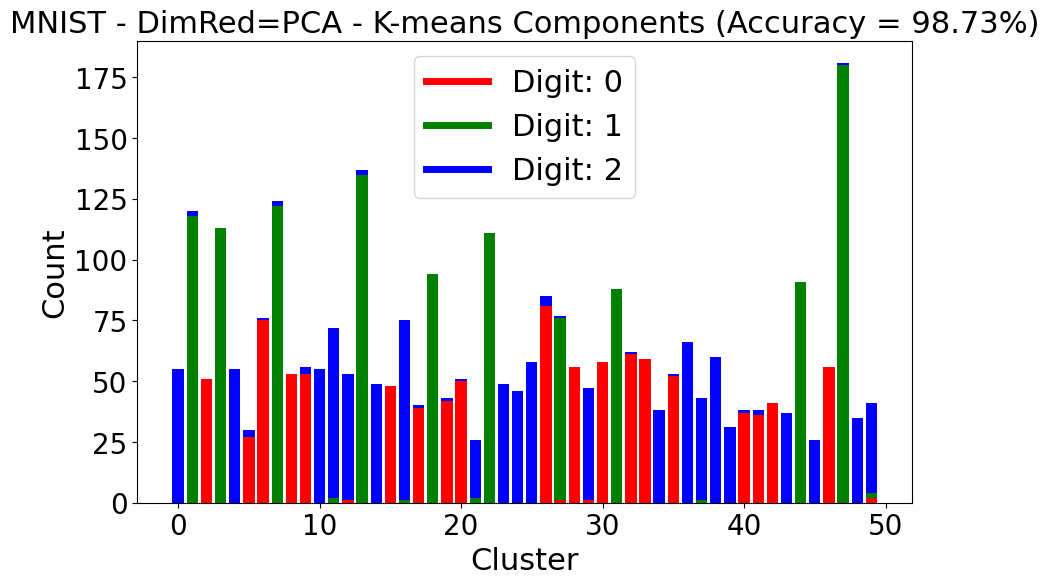

In [24]:
fontsize = 22
plt.figure(figsize=(10, 6))
for bucket_num, labels in buckets.items():
    bottom = 0
    for label_num in np.unique(labels):
        l = sum(labels == label_num)
        plt.bar(bucket_num, l, bottom=bottom, color=colors[label_num])
        bottom += l

# get accuracy
wrong_count = 0
for bucket_num, labels in buckets.items():
    counts = np.bincount(labels)
    most_common = np.argmax(counts)
    wrong_count += sum(labels != most_common)
acc = 1 - (wrong_count / len(y_test))

plt.title(f'{DATASET_STR} - DimRed={DIM_RED_METHOD} - K-means Components (Accuracy = {acc:.2%})', fontsize=fontsize)
plt.xlabel('Cluster', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)

custom_lines = [plt.Line2D([0], [0], color=colors[0], lw=5),
                plt.Line2D([0], [0], color=colors[1], lw=5),
                plt.Line2D([0], [0], color=colors[2], lw=5)]
plt.legend(custom_lines, ['Digit: 0', 'Digit: 1', 'Digit: 2'], fontsize=fontsize)

plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)

path = (f'/Users/sdale/repos/gatech/machine_learning/unsupervised_learning/final_results/step_3/'+
        f'bars_{DATASET_NAME.lower()}_{METHOD.NAME.lower()}_{DIM_RED_METHOD.lower()}.png')
print(path)
os.makedirs(os.path.dirname(path), exist_ok=True)
plt.savefig(path, bbox_inches='tight')